In [5]:
import torch
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
from torchvision import datasets, transforms
from tqdm import tqdm 
import time
from torch.utils.data import random_split, Dataset, DataLoader
#from torchvision.models.resnet import ResNet18_Weights
import pickle
import random
from torch.optim import SGD
from torch.optim.lr_scheduler import CosineAnnealingLR
import statistics
import matplotlib.pyplot as plt
import csv
from itertools import combinations, permutations

seed = 42
torch.manual_seed(seed)

In [6]:
if torch.backends.mps.is_available():
    device = "mps"
elif torch.cuda.is_available():
    device = "cuda:5" # change the available gpu number
else:
    device = "cpu"

## Load Dataset

In [7]:
# Define data transforms
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

In [8]:
# Load CIFAR10 datasets
train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform_test)

# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


## Parameters

In [18]:
print(len(train_dataset))

50000


In [9]:
num_classes = 10
subset_fraction = 0.1
epochs = 40
model_name = "LeNet"
optimizer_name = "adam"

## Load Model

In [10]:
from models.LeNet_model import LeNet
from models.resent_models import get_resent101_model, get_resent18_model

model = LeNet(out_classes=num_classes)

In [11]:
from utils.milo.subset_sampler import RandomSubsetSampler
from utils.milo.subset_dataset import SubDataset

## Experiment 

#### Optimizer

In [12]:
if optimizer_name=="SGD_ann":
    optimizer = SGD(model.parameters(), lr=0.05, momentum=0.9, weight_decay=5e-4)
    lr_scheduler = CosineAnnealingLR(optimizer, T_max=10, eta_min=0)
elif optimizer_name=="adam":
    optimizer = torch.optim.Adam(model.parameters())

#### Train Loop

In [13]:
import os
print(os.getcwd())

/raid/ganesh/namitha/yash/BTP/neural-submod


In [14]:
func_list = ["facility-location", "disparity-min",  "disparity-sum", "graph-cut"]

In [15]:
import os 
path = "./data/seq_submod_subset/permutation_subsets_2/"
dir_list = os.listdir(path) 

In [16]:
with open("./data/seq_submod_subset/permutation_subsets_2/facility-location_disparity-sum.pkl", "rb") as f:
    test = pickle.load(f)

In [17]:
print(len(test))

2


In [15]:
print(dir_list)

['disparity-min_graph-cut.pkl', 'graph-cut_facility-location.pkl', 'facility-location_graph-cut.pkl', 'disparity-sum_facility-location.pkl', 'disparity-min_disparity-sum.pkl', 'disparity-sum_disparity-min.pkl', 'facility-location_disparity-sum.pkl', 'graph-cut_disparity-sum.pkl', 'disparity-sum_graph-cut.pkl', 'graph-cut_disparity-min.pkl', 'facility-location_disparity-min.pkl', 'disparity-min_facility-location.pkl']


In [20]:
order_list = []
order_list.append([0, 1, 2, 3])
order_list.append([0, 1, 3, 2])
order_list.append([1, 0, 2, 3])
order_list.append([1, 0, 3, 2])
order_list.append([1, 2, 3, 0])
order_list.append([1, 2, 0, 3])
order_list.append([2, 1, 3, 0])
order_list.append([2, 1, 0, 3])
order_list.append([1, 3, 2, 0])
order_list.append([1, 3, 0, 2])
order_list.append([3, 1, 2, 0])
order_list.append([3, 1, 0, 2])

  0%|          | 0/1 [00:00<?, ?it/s]


7500
--- 0.050077199935913086 seconds ---


100%|██████████| 157/157 [00:01<00:00, 137.68it/s]


accuracy: 0.101


ValueError: x and y must have same first dimension, but have shapes (1,) and (0,)

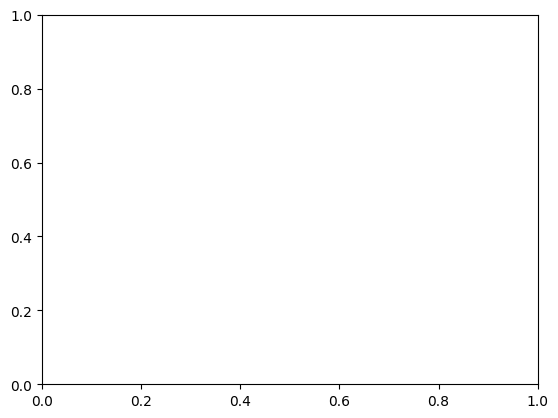

In [24]:
res = {}

for order in order_list:
    per_func_list = [func_list[i] for i in order]
    file1 = per_func_list[0]+"_"+per_func_list[1]
    file2 = per_func_list[2]+"_"+per_func_list[3]

    data1 = None
    data2 = None

    if f"{file1}.pkl" in dir_list and f"{file2}.pkl" in dir_list:
        try:
            with open(f"./data/seq_submod_subset/permutation_subsets_2/{file1}.pkl", "rb") as f:
                data1 = pickle.load(f)
            with open(f"./data/seq_submod_subset/permutation_subsets_2/{file2}.pkl", "rb") as f:
                data2 = pickle.load(f)
        except:
            print("Error while loading the data")
            continue
        
    if data1 is None or data2 is None:
        print("data is None")
        continue 

    if model_name=="LeNet":
        model = LeNet()
    elif model_name=="resnet18":
        model = get_resent18_model()
    elif  model_name=="resnet101":
        model = get_resent101_model()

    model = model.to(device=device)
    loss_fn = nn.CrossEntropyLoss()

    if optimizer_name=="SGD_ann":
        optimizer = SGD(model.parameters(), lr=0.05, momentum=0.9, weight_decay=5e-4)
        lr_scheduler = CosineAnnealingLR(optimizer, T_max=10, eta_min=0)
    elif optimizer_name=="adam":
        optimizer = torch.optim.Adam(model.parameters())

    # Train the model
    model.train()
    start_time = time.time()

    accuracy_list = []

    for epoch in tqdm(range(epochs)):
        # Train loop
        if epoch==0:
            train_data = list(set(data1[0]) | set(data2[0]))
            random.shuffle(train_data)
            if len(train_data) > int(0.3*len(train_dataset)):
                train_data = train_data[:int(0.3*len(train_dataset))]

            sub_dataset = SubDataset(indices=train_data, dataset=train_dataset)
            subset_train_dataloader = DataLoader(sub_dataset, batch_size=64, shuffle=True)
        elif epoch==20:
            train_data = list(set(data1[1]) | set(data2[1]))
            random.shuffle(train_data)
            if len(train_data) > int(0.15*len(train_dataset)):
                train_data = train_data[:int(0.15*len(train_dataset))]

            sub_dataset = SubDataset(indices=train_data, dataset=train_dataset)
            subset_train_dataloader = DataLoader(sub_dataset, batch_size=64, shuffle=True)
        
        for images, labels in subset_train_dataloader:

            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            
            # Backward pass and update weights
            if optimizer_name=="SGD_ann":
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()  # Update model weights
                lr_scheduler.step()     
            elif optimizer_name=="adam":
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        
        # Evaluate on test set
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_dataloader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                predictions = torch.argmax(outputs, dim=1)
                correct += (predictions == labels).sum().item()
                total += labels.size(0)

        accuracy = correct / total
        accuracy_list.append(accuracy)

    time_taken = time.time() - start_time    
    print("--- %s seconds ---" % (time_taken))

    # Evaluate on test set
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(test_dataloader):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            predictions = torch.argmax(outputs, dim=1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    print(f"accuracy: {accuracy}")

    x = range(epochs)

    # Plot the accuracies
    plt.clf()
    plt.plot(x, accuracy_list)

    # Customize the plot (optional)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"{file1}_{file2} Accuracy Plot")

    # Display the plot
    # plt.show()
    plt.savefig(f"./results/para/plots/{file1}_{file2}.png")
    
    res[f"{file1}_{file2}"] = accuracy_list

    print(accuracy_list)

    with open(f"./results/para/accuracies/{file1}_{file2}.txt", "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(accuracy_list)
        
    with open(f"./results/para/accuracies.pkl", "wb") as f:
        pickle.dump(res, f)

In [ ]:
plt.clf()
for label, data in res.items():
    plt.plot(data, label=label)

plt.tick_params(bottom=False, labelbottom=False)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("All Accuracies")
plt.legend()
plt.savefig("./results/para/accuracies.png")